In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# デフォルトフォント設定
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W6.ttc"
font_prop = fm.FontProperties(fname=font_path)
rcParams['font.family'] = font_prop.get_name()

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


# 7日間ごとにデータを取得し、結合する関数
def get_last_days_data_in_chunks(ticker, interval="1m"):
    end_date = datetime.now()  # 現在の日付を終了日に設定
    start_date = end_date - timedelta(days=1)  # XX日前を開始日に設定
    all_data = pd.DataFrame()  # 取得した全データを格納するデータフレーム

    while start_date < end_date:
        # 7日間の終了日を設定
        period_end = min(start_date + timedelta(days=7), end_date)
        print(f"Fetching data from {start_date.strftime('%Y-%m-%d')} to {period_end.strftime('%Y-%m-%d')}")
        
        # データの取得
        data = yf.download(ticker, interval=interval, start=start_date.strftime('%Y-%m-%d'), end=period_end.strftime('%Y-%m-%d'))
        
        # データを結合
        all_data = pd.concat([all_data, data])
        
        # 次の開始日に移動
        start_date = period_end

    return all_data

# データの取得
ticker = "^N225"
data = get_last_days_data_in_chunks(ticker)

# 取得したデータの確認
print(data)

Fetching data from 2025-02-03 to 2025-02-04
[*********************100%%**********************]  1 of 1 completed
                                   Open          High           Low  \
Datetime                                                              
2025-02-03 09:00:00+09:00  38932.660156  38948.609375  38899.460938   
2025-02-03 09:01:00+09:00  38895.089844  38895.089844  38831.750000   
2025-02-03 09:02:00+09:00  38853.640625  38899.578125  38853.640625   
2025-02-03 09:03:00+09:00  38913.500000  38913.500000  38683.968750   
2025-02-03 09:04:00+09:00  38748.488281  38819.109375  38748.488281   
...                                 ...           ...           ...   
2025-02-03 15:25:00+09:00  38461.289062  38461.289062  38461.289062   
2025-02-03 15:26:00+09:00  38461.289062  38461.289062  38461.289062   
2025-02-03 15:27:00+09:00  38461.289062  38461.289062  38461.289062   
2025-02-03 15:28:00+09:00  38461.289062  38461.289062  38461.289062   
2025-02-03 15:29:00+09:00  38461.28

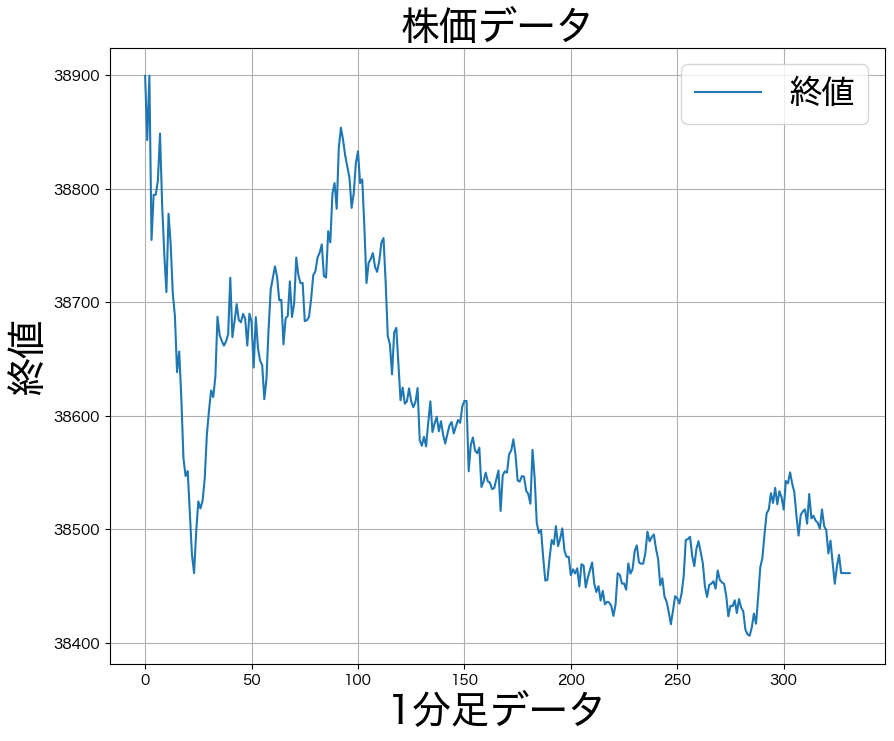

In [4]:
def plot_stock_data(data):
    if data.empty:
        print("No data available to plot.")
        return
    
    # 日時をリセット（必要に応じて調整）
    if 'Datetime' in data.columns:
        data['Datetime'] = pd.to_datetime(data['Datetime'])
    else:
        data = data.reset_index()
        data['Datetime'] = pd.to_datetime(data['index']) if 'index' in data.columns else data.index

    # 終値（Close）の可視化
    plt.figure(figsize=(10, 8))
    sns.lineplot(x=data['Datetime'], y=data['Close'], label="終値")
    plt.title("株価データ", fontsize=28)
    plt.xlabel("1分足データ", fontsize=28)
    plt.ylabel("終値", fontsize=28)
    plt.rc('font', size=12)  # デフォルトフォントサイズ
    plt.rc('axes', titlesize=28, labelsize=28)  # タイトルとラベルサイズ
    plt.rc('xtick', labelsize=20)  # X軸目盛りの文字サイズ
    plt.rc('ytick', labelsize=20)  # Y軸目盛りの文字サイズ
    plt.legend(fontsize=24)
    plt.grid(True)
    plt.show()

# 可視化の実行
plot_stock_data(data)


In [5]:
# 欠損値の確認
missing_values = data.isnull().sum()

print("欠損値の数:\n", missing_values)

# 欠損値のある行を削除
data = data.dropna()

欠損値の数:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [6]:
# 四本値の範囲を確認（負の値や極端に高い値を検出）
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    print(f'{column} の異常値:', data[(data[column] < 0) | (data[column] > data[column].mean() + 3 * data[column].std())])

# 異常値を補正（例: 負の値を0に置き換える）
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data[column] = np.where(data[column] < 0, 0, data[column])

Open の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
High の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Low の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Close の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Volume の異常値: Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


In [7]:
# 必要な列のみを選択して標準化
scaler = StandardScaler()
data[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [8]:
# 終値の1日後の値を追加
data['Next_Close'] = data['Close'].shift(-1)

# 終値が上がるか下がるかのラベルを作成
#　Tureなら1、Falseなら0
data.loc[:, 'Price_Up'] = (data['Next_Close'] > data['Close']).astype(int)

# 最後の行は次の値がないため削除
data = data.dropna()

print(data[[ 'Close', 'Next_Close', 'Price_Up']].head())

                              Close  Next_Close  Price_Up
Datetime                                                 
2025-02-03 09:00:00+09:00  2.746787    2.267775         0
2025-02-03 09:01:00+09:00  2.267775    2.747778         1
2025-02-03 09:02:00+09:00  2.747778    1.524236         0
2025-02-03 09:03:00+09:00  1.524236    1.860401         1
2025-02-03 09:04:00+09:00  1.860401    1.861160         1


In [9]:
columns_to_scale = ['Open', 'High', 'Low', 'Close', ]

# 特徴量とラベルの定義
X = data[columns_to_scale]
y = data['Price_Up']

In [10]:
#単純なランダムフォレストによる勝率の計算
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレストの学習と予測
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 正解率の計算
accuracy = accuracy_score(y_test, y_pred)
print(f'ランダムフォレストのAccuracy: {accuracy:.3f}')

ランダムフォレストのAccuracy: 0.522


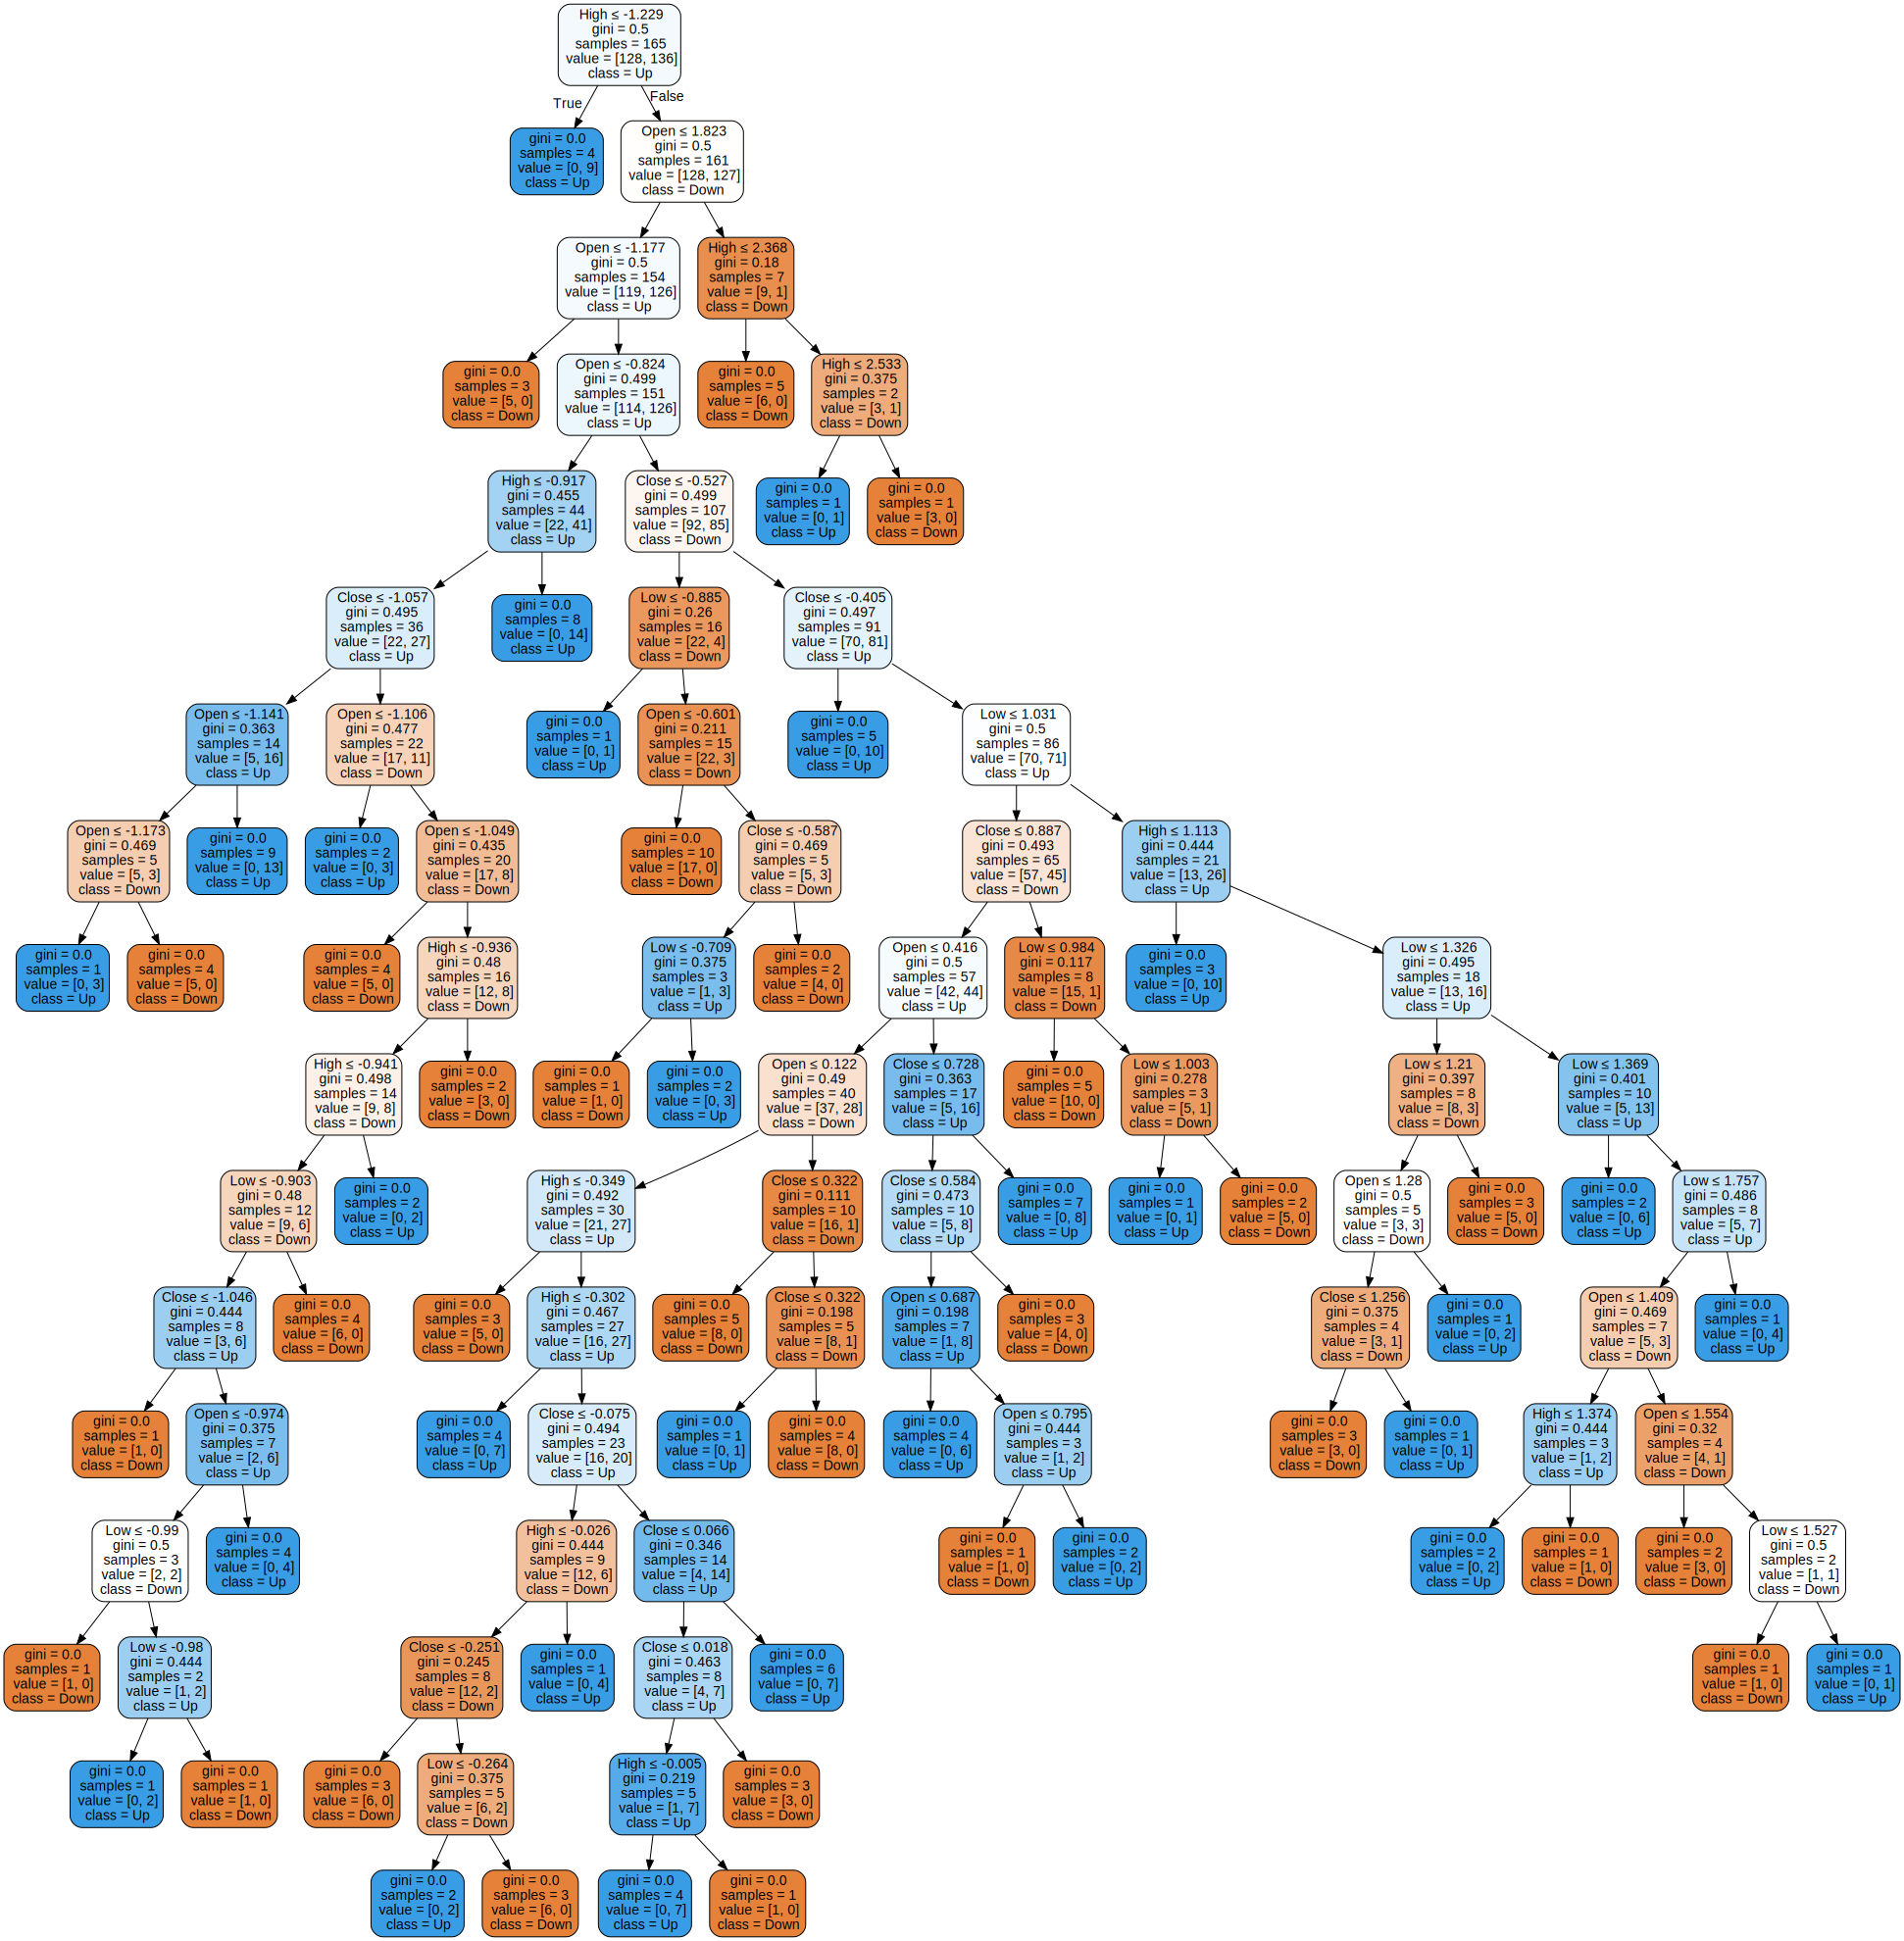

In [11]:
from sklearn.tree import export_graphviz
import graphviz

# 決定木の可視化（1本の決定木を抽出）
estimator = rf_model.estimators_[0]

# 決定木の可視化用データを作成
dot_data = export_graphviz(estimator, out_file=None, 
                           feature_names=columns_to_scale, 
                           class_names=['Down', 'Up'], 
                           filled=True, rounded=True, 
                           special_characters=True)

# Graphvizで描画
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # PDFとして出力
graph
